# COLLEGE UPWARD MOBILITY

Every year journalists and economists (USA today, the Wall Street journal, Forbes etc.) rank the best undergraduate colleges in the USA. While the top colleges are associated with good employment outcomes, they are expensive, highly selective and largely exclusive. For the majority of students in America, attending college is a means to increase economic mobility, that is, to be able earn more than a high school graduate. For many of these students attending top tier ivy leagues is not an option because of family income and their SAT scores. Here I look at which colleges pave the way for higher economic mobility. 

## Importing and cleaning the data from College Scorecard

In [528]:
import pandas as pd
import json
import urllib2
from pandas.io.json import json_normalize
import re
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [ ]:
# I imported (~45) variables of interest to the csv file from the data dictionatry provided by College score card
# https://collegescorecard.ed.gov/data/documentation/

Allvariables = pd.read_csv('coreVariables.csv')

# convert df to a list of variables in the format required by the API query
#API query format is year.category.developer-friendly name
#format year.category.developer-friendly name 

#adding a . to category
Allvariables['dev-category'] = Allvariables['dev-category'].astype(str) +'.' 

#variables that are associated with the school and don't change with year 
school_variables = Allvariables[Allvariables['dev-category'].isin(['school.'])]

#variables that change with year
year_variables = Allvariables[~Allvariables['dev-category'].isin(['school.'])]

#concatenating category and developer-friendly name and converting it to a list
year_var_name = list(year_variables[['dev-category','developer-friendly name']].astype(str).sum(axis=1))
school_var_name = list(school_variables[['dev-category','developer-friendly name']].astype(str).sum(axis=1))
#remove the root variable
year_var_name.remove('root.id')

In [304]:
#Only download all the  data from the api if not already downloaded 
#once downloaded the data is saved as a csv format

if os.path.exists("year_data.csv"):
    print("Year data already extracted from API")
    allyears_df = pd.read_csv("year_data.csv")
else:   
    # for data that changes by year, loop through the years and download all the data
    #number of years
    years = range(1997,2016)
    #number of pages per year
    n = int(7593/100)+1 #number of total entries per year / number of enteries per page: 100 is the max. 
    #empty list of data frames for all the data
    alldata =[]
    for year in years:
        #build the query from var_name
        QueryAPI= str(year)+'.'+(','+str(year)+'.').join(year_var_name)
        #create empty list to store all page dfs for a year 
        allpages =[]
        print "Downloading year {}".format(year)
        #loop to get all pages (n) for a year (API only allows a max of 100 enteries per page)
        for i in xrange(0, n):
            try:
                print "Downloading Page {}".format(i)
                api ='https://api.data.gov/ed/collegescorecard/v1/schools?fields=school.name,id,{}&_per_page=100&page={}&api_key=7EfsgcFY3JfMxQJ7tAW0Cjqamb77iOHPbpdBXTP6'.format(QueryAPI, str(i))
                req = urllib2.Request(api)
                response = urllib2.urlopen(req)
                response_read = response.read()
                json_data=json.loads(response_read)
                #store the results of each api call (pages) to a data frame
                df = json_normalize(json_data, 'results', meta = 'metadata')
                #removing the year from the column title so that we can concatenate columns across all years
                replace = str(year)+'.' 
                df.columns=[re.sub(replace,'', s) for s in df.columns] 
                #make a list of dataframes
                allpages.append(df)
            except:
                pass  
        #combine all df in the list to a single df per year    
        all_pages_df = pd.concat(allpages)
        #add a year column
        all_pages_df['year'] =year
        #store all dfs per year in a list 
        alldata.append(all_pages_df)
    #combine all df in the list to a single df for all years     
    allyears_df = pd.concat(alldata)
    #write the df to a csv file
    allyears_df.to_csv('year_data.csv')
 

Main data already extracted from API


In [527]:
if os.path.exists("school_data.csv"):
    print("School data already extracted from API")
    allschools_df = pd.read_csv("school_data.csv")
else:
    n = int(7593/100)+1 #number of total entries per year / number of enteries per page: 100 is the max. 
    #empty list of data frames for all the data
    alldata =[]
    QueryAPI= (',').join(school_var_name)
    #loop to get all pages (n) (API only allows a max of 100 enteries per page)
    for i in xrange(0, n):
        try:
            print "Downloading Page {}".format(i)
            api ='https://api.data.gov/ed/collegescorecard/v1/schools?fields=school.name,id,{}&_per_page=100&page={}&api_key=7EfsgcFY3JfMxQJ7tAW0Cjqamb77iOHPbpdBXTP6'.format(QueryAPI, str(i))
            req = urllib2.Request(api)
            response = urllib2.urlopen(req)
            response_read = response.read()
            json_data=json.loads(response_read)
            #store the results of each api call (pages) to a data frame
            df = json_normalize(json_data, 'results', meta = 'metadata')
            #removing the year from the column title so that we can concatenate columns across all years
            replace = str(year)+'.' 
            df.columns=[re.sub(replace,'', s) for s in df.columns] 
            #make a list of dataframes
            alldata.append(df)
        except:
            pass  
    #combine all df in the list to a single df for all years     
    allschools_df = pd.concat(alldata)
    #write the df to a csv file
    allschools_df.to_csv('school_data.csv')
 

School data already extracted from API


In [230]:
print(allyears_df.shape) #number of records
#make sure all numeric columns are numeric
print(allyears_df.info())
#the data types look good but there are a number of null entries 

(96716, 35)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96716 entries, 0 to 96715
Data columns (total 35 columns):
Unnamed: 0                                                      96716 non-null int64
admissions.admission_rate.overall                               21230 non-null float64
admissions.sat_scores.average.overall                           12156 non-null float64
aid.federal_loan_rate                                           4234 non-null float64
aid.loan_principal                                              55183 non-null float64
aid.pell_grant_rate                                             9717 non-null float64
cost.tuition.in_state                                           34129 non-null float64
cost.tuition.out_of_state                                       33924 non-null float64
earnings.10_yrs_after_entry.median                              8046 non-null float64
earnings.10_yrs_after_entry.not_working_not_enrolled.overall    8787 non-null float64
student.avg_dep

## Missing data

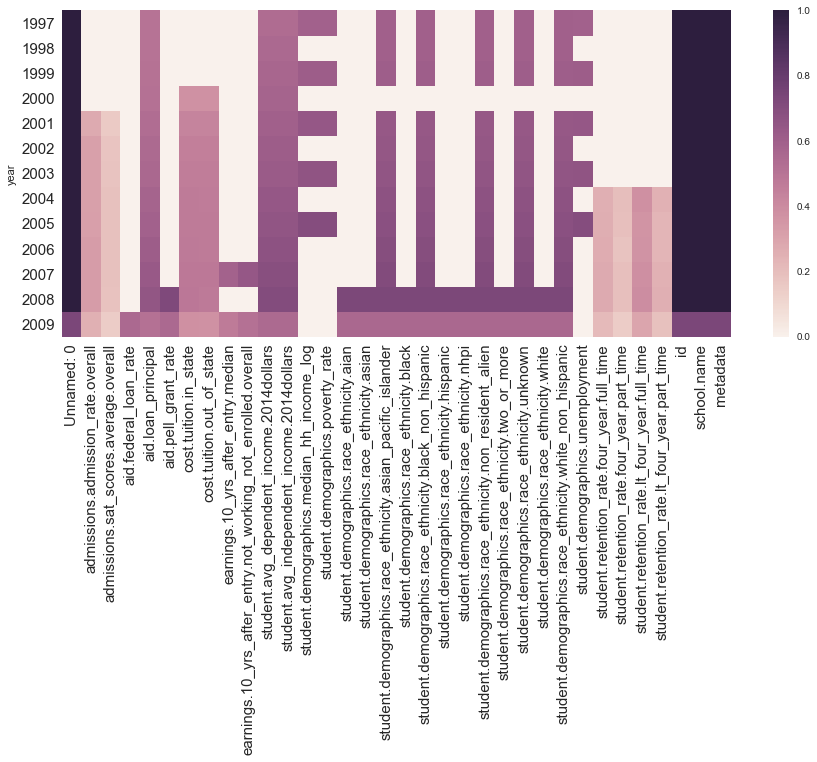

In [273]:
%matplotlib inline 
missing = allyears_df.groupby('year').count()
missing = missing/7593 #dividing it by the total to get a proportion.
plt.figure(figsize=(15,6))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.heatmap(missing)
plt.show()## Missing data

The college scorecard data is missing for a number of field in many years especially, the median earnings 10 years after graduation. This data is only available for 2008-2009. Since 2009 is the most comprehensive data collection year. I will focus on the data collected in 2009.  

In [312]:
print(allschools_df.shape) #number of records
#make sure all numeric columns are numeric
print(allschools_df.info())
#the data types look good 

(7593, 18)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7593 entries, 0 to 92
Data columns (total 18 columns):
id                                             7593 non-null int64
school.carnegie_basic                          7147 non-null float64
school.carnegie_size_setting                   7147 non-null float64
school.carnegie_undergrad                      7147 non-null float64
school.degree_urbanization                     0 non-null object
school.locale                                  7147 non-null float64
school.men_only                                7147 non-null float64
school.minority_serving.aanipi                 7147 non-null float64
school.minority_serving.annh                   7147 non-null float64
school.minority_serving.hispanic               7147 non-null float64
school.minority_serving.historically_black     7147 non-null float64
school.minority_serving.nant                   7147 non-null float64
school.minority_serving.predominantly_black    7147 non-null f

In [320]:
#replace blank values (coded as -3) with NAs
allschools_df=allschools_df.replace(-3.0, np.NaN)

## Carnegie classifications for colleges 

In [321]:
#All these classifications were coded using integers with associated categorical data provided in the data dictionary. 
#Here I change the integers to classifications using the dictionary (imported as a csv)
## Carnegie school type classification
## Using the data dictionary 
carnegie = pd.read_csv('Carnegie_notations.csv', header=None)
carnegie_dict =dict(carnegie.values)
allschools_df["school.carnegie_basic"].replace(carnegie_dict, inplace=True)
print(allschools_df["school.carnegie_basic"].value_counts(dropna=False))
# almost a thrid of the colleges are not classified 

NaN                                                                                             3461
Special Focus Two-Year: Health Professions                                                       507
Master's Colleges & Universities: Larger Programs                                                387
Baccalaureate Colleges: Diverse Fields                                                           355
Associate's Colleges: High Transfer-Mixed Traditional/Nontraditional                             284
Special Focus Four-Year: Faith-Related Institutions                                              264
Baccalaureate Colleges: Arts & Sciences Focus                                                    253
Master's Colleges & Universities: Medium Programs                                                173
Special Focus Four-Year: Other Health Professions Schools                                        150
Associate's Colleges: High Transfer-High Nontraditional                                    

In [322]:
## Carnegie undergrad classification
carnegie_ug = pd.read_csv('Carnegie_undergrad.csv', header=None)
carnegie_ug_dict =dict(carnegie_ug.values)
allschools_df["school.carnegie_undergrad"].replace(carnegie_ug_dict, inplace=True)
print(allschools_df["school.carnegie_undergrad"].value_counts(dropna=False))
# almost a thrid of the colleges are not classified 
#remove all the graduate professional only colleges and two-year colleges

Not applicable                                                 2653
Four-year, full-time, inclusive, higher transfer-in             550
Two-year, higher part-time                                      503
NaN                                                             446
Four-year, higher part-time                                     408
Two-year, mixed part/full-time                                  400
Two-year, higher full-time                                      367
Four-year, full-time, selective, higher transfer-in             329
Not classified (Exclusively Graduate)                           301
Four-year, medium full-time, inclusive, higher transfer-in      294
Four-year, full-time, more selective, lower transfer-in         292
Four-year, full-time, inclusive, lower transfer-in              264
Two-year, medium full-time                                      243
Four-year, medium full-time , selective, higher transfer-in     145
Four-year, full-time, selective, lower transfer-

In [323]:
## Carnegie size classification
carnegie_sz = pd.read_csv('Carnegie_size.csv', header=None)
carnegie_sz_dict =dict(carnegie_sz.values)
allschools_df["school.carnegie_size_setting"].replace(carnegie_sz_dict, inplace=True)
print(allschools_df["school.carnegie_size_setting"].value_counts(dropna=False))
# almost a thrid of the colleges are not classified 

Not applicable                                     2653
Four-year, very small, primarily nonresidential     777
Two-year, very small                                491
Two-year, small                                     448
NaN                                                 446
Four-year, small, highly residential                331
Two-year, medium                                    325
Exclusively graduate/professional                   276
Four-year, small, primarily nonresidential          246
Four-year, very small, highly residential           236
Four-year, medium, primarily nonresidential         200
Four-year, small, primarily residential             186
Two-year, large                                     174
Four-year, medium, primarily residential            170
Four-year, large, primarily nonresidential          140
Four-year, medium, highly residential               139
Four-year, large, primarily residential             124
Four-year, very small, primarily residential    

In [324]:
# this columnn is non-existant so remove from df 
allschools_df.drop('school.degree_urbanization', axis=1, inplace=True)

In [325]:
## Locale classification
locale = pd.read_csv('urbanization.csv', header=None)
locale_dict =dict(locale.values)
allschools_df["school.locale"].replace(locale_dict, inplace=True)

print(allschools_df["school.locale"].value_counts(dropna=False))
# almost a thrid of the colleges are not classified 
# this columnn is non-existance do remove from df 


Suburb: Large       1881
City: Large         1636
City: Small          968
City: Midsize        845
Town: Distant        451
NaN                  449
Rural: Fringe        380
Town: Remote         338
Suburb: Midsize      205
Suburb: Small        137
Town: Fringe         122
Rural: Distant       120
Rural: Remote         61
Name: school.locale, dtype: int64


In [529]:
#merge all_schools df with the 2009 data 
df_2009 = allyears_df[(allyears_df['year']==2009)]
df_2009 = df_2009.merge(allschools_df,  left_on='id', right_on='id')


## I limit my focus to 4-year, non-specialized, degree granting institutions 

In [422]:
#only look at 4-year undergrad programs
ug_4_yr_institutions = ['Four-year, higher part-time','Four-year, full-time, inclusive, higher transfer-in',
                       'Four-year, full-time, selective, higher transfer-in','Four-year, full-time, more selective, lower transfer-in',
                       'Four-year, medium full-time, inclusive, higher transfer-in','Four-year, full-time, inclusive, lower transfer-in',
                       'Four-year, medium full-time , selective, higher transfer-in','Four-year, full-time, selective, lower transfer-in',
                       'Four-year, full-time, more selective, higher transfer-in','Four-year, medium full-time, inclusive, lower transfer-in',
                       'Four-year, medium full-time, selective, lower transfer-in']

#removed specialized associates degree colleges and professional programs
remove_special =['Special Focus Two-Year: Health Professions',
                 'Special Focus Two-Year: Arts & Design',
                 'Special Focus Two-Year: Other Fields',
                 'Special Focus Two-Year: Technical Professions',
                 "Associate's Colleges: High Transfer-High Nontraditional",
                 "Associate's Colleges: High Vocational & Technical-High Nontraditional",
                 "Special Focus Four-Year: Medical Schools & Centers", 
                 "Associate's Colleges: High Transfer-High Nontraditional", 
                 "Associate's Colleges: High Transfer-Mixed Traditional/Nontraditional",
                 "Associate's Colleges: Mixed Transfer/Vocational & Technical-Mixed Traditional/Nontraditional",
                 "Associate's Colleges: High Vocational & Technical-High Traditional",
                 "Associate's Colleges: Mixed Transfer/Vocational & Technical-High Nontraditional",
                 "Special Focus Four-Year: Law Schools",
                 "Associate's Colleges: Mixed Transfer/Vocational & Technical-High Traditional"                      
                ]
df_2009_ug = df_2009[df_2009['school.carnegie_undergrad'].isin(ug_4_yr_institutions)]
df_2009_ug = df_2009_ug[~df_2009_ug['school.carnegie_basic'].isin(remove_special)]


Master's Colleges & Universities: Larger Programs                      297
Baccalaureate Colleges: Diverse Fields                                 281
Baccalaureate Colleges: Arts & Sciences Focus                          185
Master's Colleges & Universities: Medium Programs                      133
Special Focus Four-Year: Faith-Related Institutions                    128
Master's Colleges & Universities: Small Programs                        91
Baccalaureate/Associate's Colleges: Mixed Baccalaureate/Associate's     90
Special Focus Four-Year: Arts, Music & Design Schools                   86
Doctoral Universities: Highest Research Activity                        84
Doctoral Universities: Higher Research Activity                         82
Doctoral Universities: Moderate Research Activity                       68
Special Focus Four-Year: Other Health Professions Schools               57
Baccalaureate/Associate's Colleges: Associate's Dominant                54
Special Focus Four-Year: 

## Economic mobility:
I calculated economic mobility based of the increase in median income earned in proportion to family income earned prior to attending college.  
## Debt to income
I also calculated the amount of debt incured relative to the income that students earned after college

In [476]:
#calculate how much more students earn on average after attending the college
df_2009_ug['mobility'] = (df_2009_ug['earnings.10_yrs_after_entry.median'])/df_2009_ug['student.avg_dependent_income.2014dollars']  

df_2009_ug['debt_income_ratio'] = df_2009_ug['aid.loan_principal']/df_2009_ug['earnings.10_yrs_after_entry.median']


## The top debt incuring institutions 
The 'starving artist'is a trope that lives up to its names. The top debt incurring institutions largely focus on music and arts.    

In [423]:
df_2009_ug.sort_values('debt_income_ratio', ascending =False)[['school.name_x','debt_income_ratio']].head(10)

,school.name_x,debt_income_ratio
2196,Platt College-Aurora,1.042674
2328,Nossi College of Art,0.751174
2274,Kansas City Art Institute,0.711122
3274,Brooks Institute,0.688111
3628,Beulah Heights University,0.686332
1071,Southwest University of Visual Arts-Tucson,0.661197
2561,Manhattan School of Music,0.647321
2065,Cleveland Institute of Art,0.647106
2568,The Juilliard School,0.629596
3466,Maharishi University of Management,0.622070


## Institutions with top earnings
Many of of institutions with high median incomes focus on applied fields like the health sciences and technology. Surprisingly, Ivy leagues do not make the cut for the top 10 higher earning institutions.  

In [425]:
df_2009_ug.sort_values('earnings.10_yrs_after_entry.median', ascending =False)[['school.name_x','earnings.10_yrs_after_entry.median']].head(10)

,school.name_x,earnings.10_yrs_after_entry.median
5204,MCPHS University,119700.0
1661,Albany College of Pharmacy and Health Sciences,116000.0
3552,Samuel Merritt University,109700.0
3903,Massachusetts Institute of Technology,92000.0
3287,California Institute of Technology,90200.0
5424,United States Merchant Marine Academy,86000.0
1063,Harvey Mudd College,83200.0
5309,Stevens Institute of Technology,82000.0
3888,Maine Maritime Academy,81900.0
3613,Georgetown University,80200.0


## Selective schools admit a student body that is wealthy
What is remarkable, albiet not completely unexpected, is that schools that are more selective (those requiring higher SAT scores) generally admit a student body that is wealthy. Data on family income and SAT scores show that kids from poorer families tend do do worse on the SATs (https://economix.blogs.nytimes.com/2009/08/27/sat-scores-and-family-income/). What this means for upward mobility is that top tier, selective colleges, are not well-suited to increase the upward mobility of lower income families.   

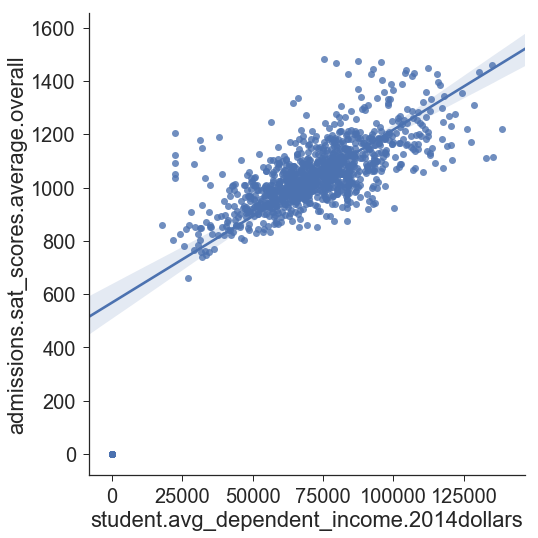

In [532]:
%matplotlib inline
sns.set(style="ticks", color_codes=True, font_scale=2 )
sns.lmplot(x="student.avg_dependent_income.2014dollars", y="admissions.sat_scores.average.overall", data=df_2009_ug, size =8)
plt.show()

## Family income, earnings, college debt,  SATs and economic mobility
The college data shows a positive associations between family income, SAT scores, tuition paid for college, debt incurred,  and the amount that students earn post-graduation. In simple term these data suggest that, weathier kids, get better SAT scores, go to more expensive colleges, take out bigger student loans but also tend to make more money post graduation. Upward mobility is negatively associated with many of these factors. Attending college increases the upward mobility of poor families more than it does for wealthier families and mobility is greater when students go cheaper colleges.   

/Users/taniajogesh/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


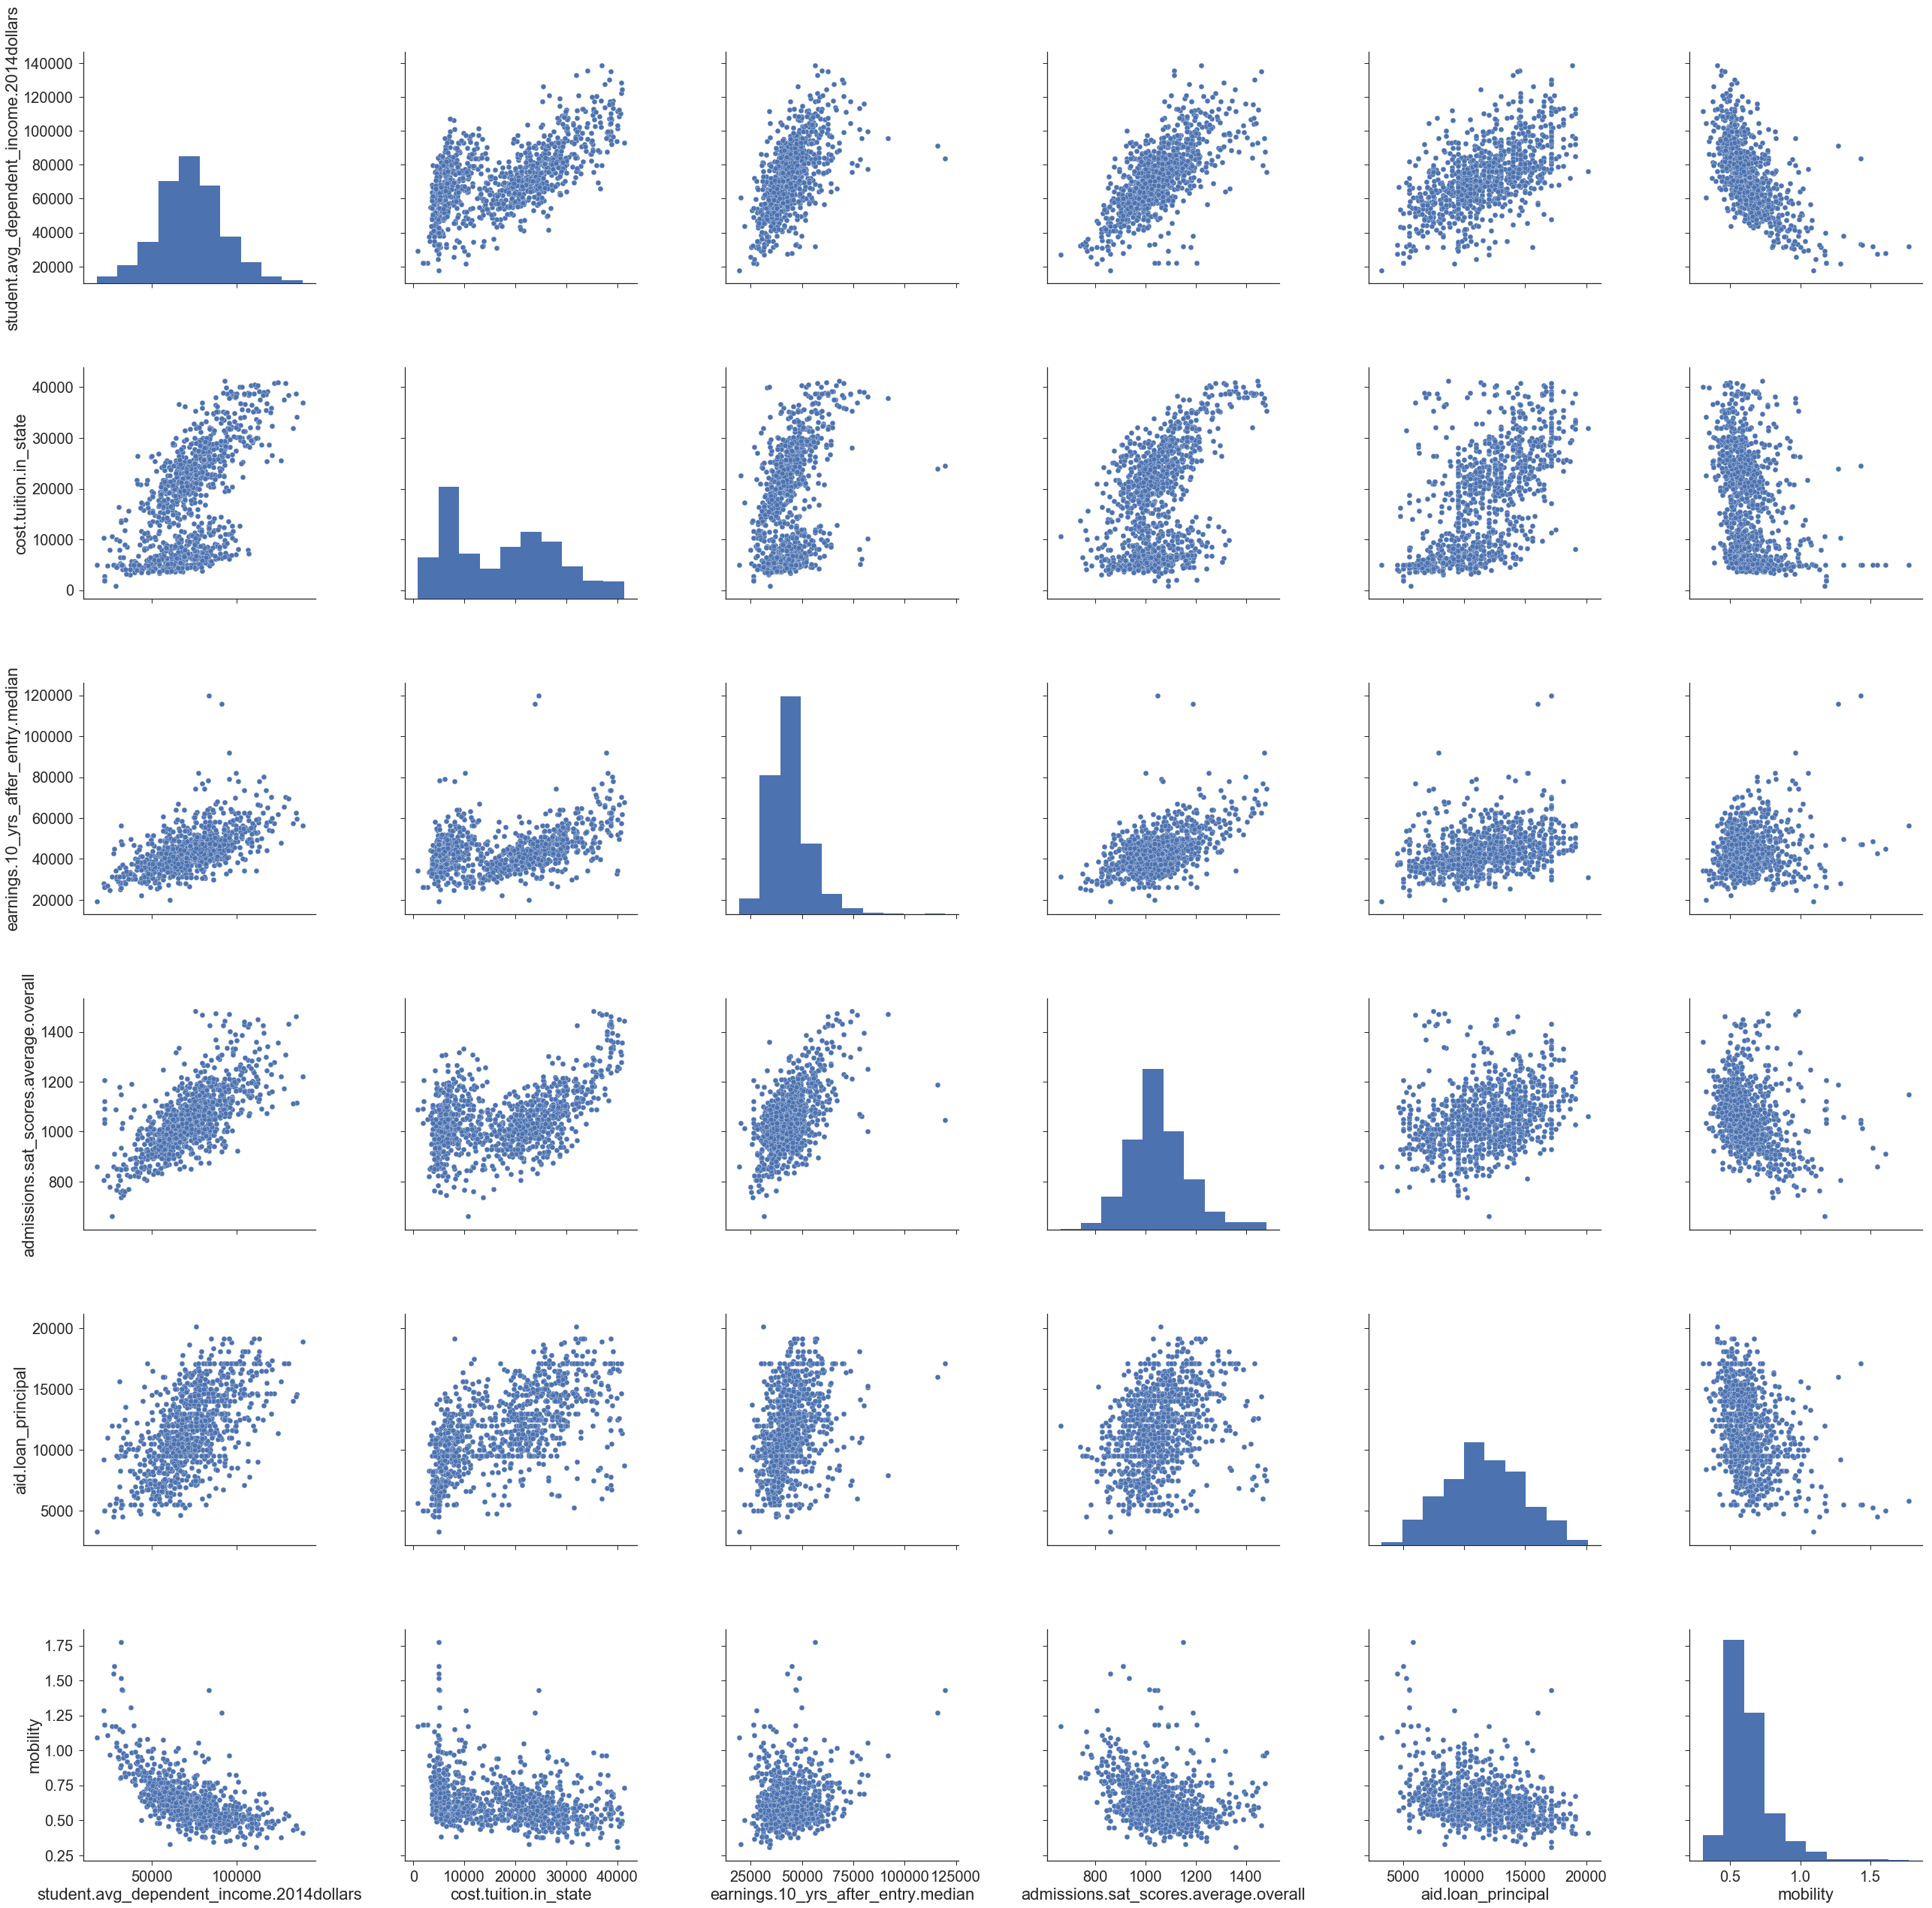

In [486]:
%matplotlib inline
sns.set(style="ticks", color_codes=True, font_scale=2 )
data = df_2009_ug[['student.avg_dependent_income.2014dollars','cost.tuition.in_state',
                   'earnings.10_yrs_after_entry.median',
                   'aid.loan_principal',
                   'mobility']]
data.dropna(inplace =True)
# Create scatterplot of dataframe
sns.pairplot(data, size =6) 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()
#, 'debt_income_ratio'

## Is college type a good predictor of upward mobility?

### Applied schools (Buisness, Management, Tech related) tend to be better at increasing economic mobility that those focused on the arts

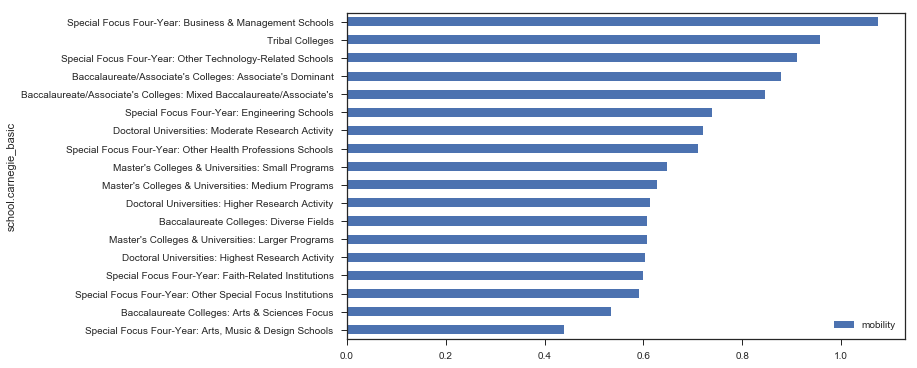

In [467]:
df_2009_ug[['school.carnegie_basic','mobility']].groupby('school.carnegie_basic').median(). \
sort_values('mobility').plot(kind='barh', figsize=(10, 6))

### Smaller, non-residential schools tend to increase economic mobility  

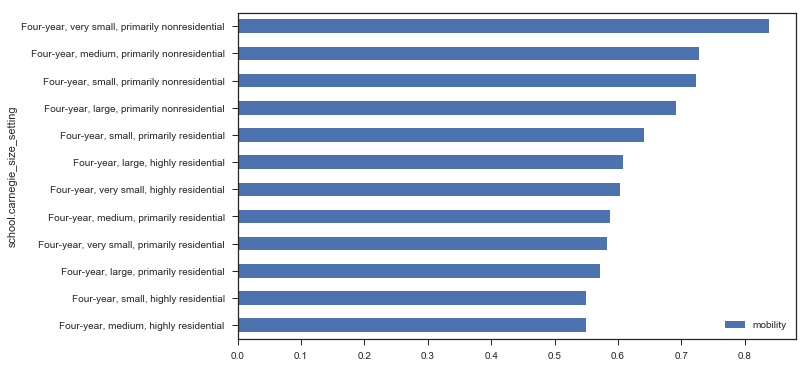

In [468]:
df_2009_ug[['school.carnegie_size_setting','mobility']].groupby('school.carnegie_size_setting').median(). \
sort_values('mobility').plot(kind='barh', figsize=(10, 6))

### Inclusive schools tend to increase economic mobility  

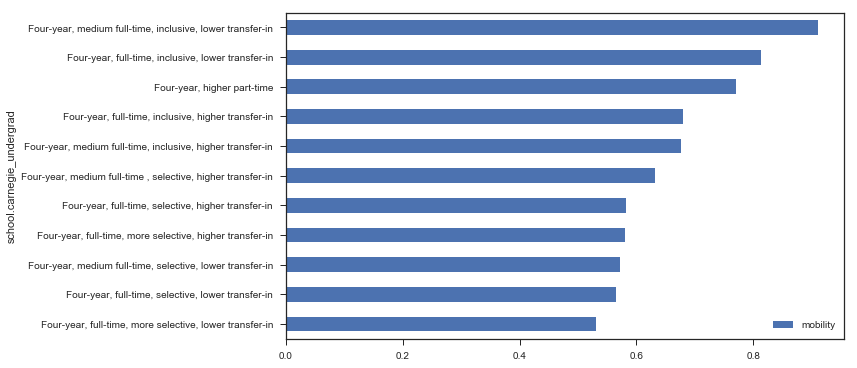

In [469]:
df_2009_ug[['school.carnegie_undergrad','mobility']].groupby('school.carnegie_undergrad').median(). \
sort_values('mobility').plot(kind='barh', figsize=(10, 6))

### Schools in large cities might be slightly better at increasing economic mobility

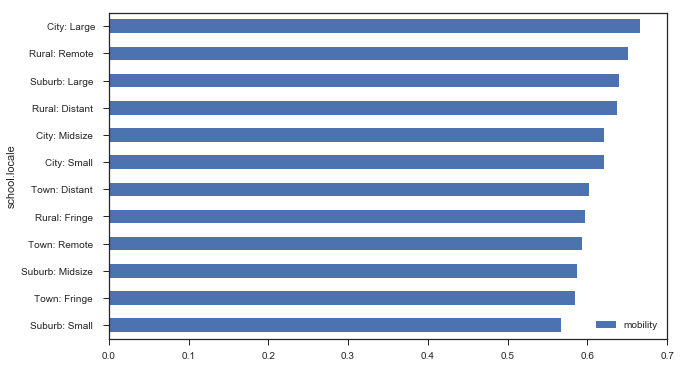

In [470]:
df_2009_ug[['school.locale','mobility']].groupby('school.locale').median(). \
sort_values('mobility').plot(kind='barh', figsize=(10, 6))

### Diversity matters for upward mobility. 
Minority serving institutions increase economic mobility overall. For any given income level and for the same cost of tuition, students attending an MSI tend to earn more money that students who don't.   

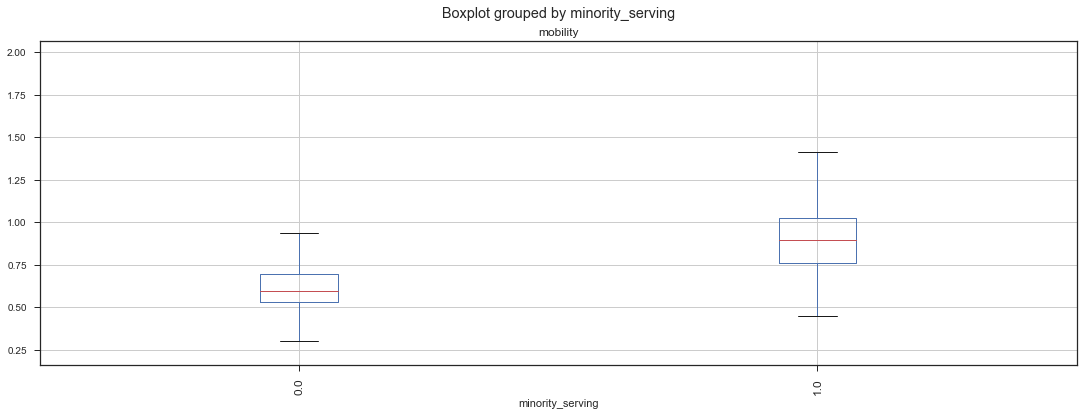

In [490]:
df_2009_ug['minority_serving']=df_2009_ug['school.minority_serving.hispanic']+ \
df_2009_ug['school.minority_serving.predominantly_black']+ \
df_2009_ug['school.minority_serving.historically_black']+df_2009_ug['school.minority_serving.tribal']+ \
df_2009_ug['school.minority_serving.aanipi']+df_2009_ug['school.minority_serving.annh']

df_2009_ug[df_2009_ug['minority_serving']>1]=1
df_2009_ug.boxplot(column='mobility', by='minority_serving', rot=90, figsize=(18, 6))


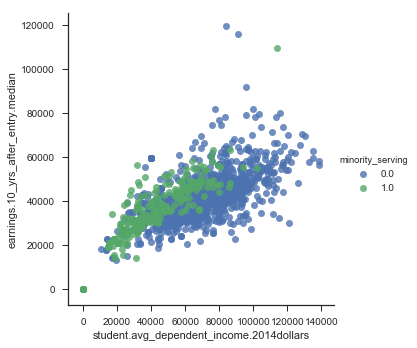

In [497]:
sns.set(style="ticks", color_codes=True, font_scale=1 )
sns.lmplot(x="student.avg_dependent_income.2014dollars", y="earnings.10_yrs_after_entry.median", 
           data=df_2009_ug, hue="minority_serving",fit_reg=False)
plt.show()

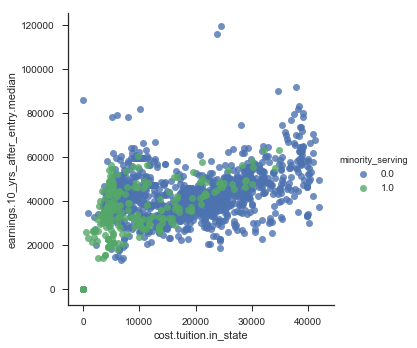

In [498]:
sns.set(style="ticks", color_codes=True, font_scale=1 )
sns.lmplot(x="cost.tuition.in_state", y="earnings.10_yrs_after_entry.median", data=df_2009_ug, 
           hue="minority_serving", fit_reg=False)
plt.show()

In [534]:
income_cat=('low','medium','high')
sat_cat=('ignore','low1','low2','medium','high')
df_2009_ug['family_income_bins'] =pd.cut(df_2009_ug['student.avg_dependent_income.2014dollars'],3, labels =income_cat)
df_2009_ug['sat_scores_bins'] =pd.cut(df_2009_ug['admissions.sat_scores.average.overall'],5, labels =sat_cat)

## What are the top colleges that increase economic mobility based on family income level and SAT score?  
I binned family income and SAT scores to three categories, low, medium and high here are the top institions per category.  

### Top 10 schools for low income families

In [509]:
df_2009_ug[df_2009_ug['family_income_bins'] =='low'].sort_values('mobility', ascending=False) \
[['school.name_x','mobility','earnings.10_yrs_after_entry.median','student.avg_dependent_income.2014dollars']].head(10)     

,school.name_x,mobility,earnings.10_yrs_after_entry.median,student.avg_dependent_income.2014dollars
2594,Boricua College,1.978176,33900.0,17137.0
1601,CUNY Bernard M Baruch College,1.773940,56500.0,31850.0
17,Dewey University-Hato Rey,1.713083,17900.0,10449.0
2211,Columbia Central University-Caguas,1.609244,22700.0,14106.0
5039,Columbia Central University-Yauco,1.609244,22700.0,14106.0
2533,CUNY Lehman College,1.604736,45000.0,28042.0
5391,CUNY Medgar Evers College,1.578470,38300.0,24264.0
2536,CUNY York College,1.549178,42700.0,27563.0
5379,CUNY New York City College of Technology,1.540693,39300.0,25508.0
1597,Globe Institute of Technology,1.528478,39100.0,25581.0


### Top 10 schools for middle income families

In [510]:
df_2009_ug[df_2009_ug['family_income_bins'] =='medium'].sort_values('mobility', ascending=False) \
[['school.name_x','mobility','earnings.10_yrs_after_entry.median','student.avg_dependent_income.2014dollars']].head(10)                                 

,school.name_x,mobility,earnings.10_yrs_after_entry.median,student.avg_dependent_income.2014dollars
5204,MCPHS University,1.430193,119700.0,83695.0
1661,Albany College of Pharmacy and Health Sciences,1.270871,116000.0,91276.0
967,California State University-Bakersfield,1.082592,51500.0,47571.0
2394,Mt Sierra College,1.078922,52400.0,48567.0
3481,University of California-San Diego,1.073500,60700.0,56544.0
3888,Maine Maritime Academy,1.056502,81900.0,77520.0
3860,Washington Adventist University,1.027311,53000.0,51591.0
1629,New Jersey Institute of Technology,1.018825,67000.0,65762.0
961,California State University-San Bernardino,1.011218,51200.0,50632.0
3543,Golden Gate University-San Francisco,1.004764,69600.0,69270.0


### Top 10 schools for high income families

In [511]:
df_2009_ug[df_2009_ug['family_income_bins'] =='high'].sort_values('mobility', ascending=False) \
[['school.name_x','mobility','earnings.10_yrs_after_entry.median','student.avg_dependent_income.2014dollars']].head(10)                                 

,school.name_x,mobility,earnings.10_yrs_after_entry.median,student.avg_dependent_income.2014dollars
3903,Massachusetts Institute of Technology,0.963775,92000.0,95458.0
3552,Samuel Merritt University,0.960612,109700.0,114198.0
2580,SUNY Maritime College,0.827405,79200.0,95721.0
5309,Stevens Institute of Technology,0.822806,82000.0,99659.0
3741,Massachusetts Maritime Academy,0.774194,78000.0,100750.0
5224,Worcester Polytechnic Institute,0.767545,79500.0,103577.0
1649,Columbia University in the City of New York,0.731405,67900.0,92835.0
2526,Cornell University,0.707873,70100.0,99029.0
3149,Duke University,0.703835,73600.0,104570.0
3613,Georgetown University,0.691612,80200.0,115961.0


### Top schools for low SAT scores

In [535]:
df_2009_ug[(df_2009_ug['sat_scores_bins'] =='low1')|(df_2009_ug['sat_scores_bins'] =='low2')]. \
sort_values('mobility', ascending=False) \
[['school.name_x','mobility','earnings.10_yrs_after_entry.median','admissions.sat_scores.average.overall']].head(10)     

,school.name_x,mobility,earnings.10_yrs_after_entry.median,admissions.sat_scores.average.overall
2536,CUNY York College,1.549178,42700.0,860.0
1948,Le Moyne-Owen College,1.283113,27900.0,805.0
1900,Paul Quinn College,1.170873,31500.0,660.0
1277,Chicago State University,1.149131,35900.0,850.0
2209,University of the Virgin Islands,1.135639,37400.0,763.0
3920,Mississippi Valley State University,1.107392,26800.0,825.0
3017,Universidad del Turabo,1.091973,19400.0,859.0
967,California State University-Bakersfield,1.082592,51500.0,889.0
2508,New Jersey City University,1.075544,46200.0,835.0
5283,Alcorn State University,1.053449,31200.0,851.0


### Top schools for middle SAT scores

In [536]:
df_2009_ug[df_2009_ug['sat_scores_bins'] =='medium'].sort_values('mobility', ascending=False) \
[['school.name_x','mobility','earnings.10_yrs_after_entry.median','admissions.sat_scores.average.overall']].head(10)     

,school.name_x,mobility,earnings.10_yrs_after_entry.median,admissions.sat_scores.average.overall
1601,CUNY Bernard M Baruch College,1.773940,56500.0,1150.0
2533,CUNY Lehman College,1.604736,45000.0,910.0
5366,CUNY John Jay College of Criminal Justice,1.515294,48500.0,935.0
5204,MCPHS University,1.430193,119700.0,1047.0
5368,CUNY Brooklyn College,1.428268,47100.0,1035.0
1661,Albany College of Pharmacy and Health Sciences,1.270871,116000.0,1188.0
3018,University of Puerto Rico-Mayaguez,1.181757,26300.0,1205.0
3020,University of Puerto Rico-Aguadilla,1.181757,26300.0,1036.0
3023,University of Puerto Rico-Cayey,1.181757,26300.0,1123.0
3024,University of Puerto Rico-Ponce,1.181757,26300.0,1091.0


### Top schools for high SAT scores

In [537]:
df_2009_ug[df_2009_ug['sat_scores_bins'] =='high'].sort_values('mobility', ascending=False) \
[['school.name_x','mobility','earnings.10_yrs_after_entry.median','admissions.sat_scores.average.overall']].head(10)     

,school.name_x,mobility,earnings.10_yrs_after_entry.median,admissions.sat_scores.average.overall
3481,University of California-San Diego,1.073500,60700.0,1247.0
988,University of California-Berkeley,0.995845,64000.0,1318.0
5271,Princeton University,0.985130,74400.0,1482.0
3903,Massachusetts Institute of Technology,0.963775,92000.0,1472.0
3735,Harvard University,0.963118,76800.0,1468.0
1540,Illinois Institute of Technology,0.929573,64200.0,1271.0
5214,Kettering University,0.919211,74400.0,1212.0
2569,Cooper Union for the Advancement of Science an...,0.829800,54800.0,1336.0
5309,Stevens Institute of Technology,0.822806,82000.0,1251.0
1859,Rice University,0.771805,64800.0,1425.0
